# Predefined functions

In [1]:
import pandas as pd

# Getting data
def getData(url, sheet_name=0, skiprows=0, truncate=-1, index_column='County Name'):
    df = pd.read_excel(url, sheet_name=sheet_name, skiprows=skiprows)
    if truncate > -1:
        df = df.truncate(before=0, after=truncate)
    df = df.set_index(index_column)
    return df

In [2]:
def config_subplot(ax, label, fontsize=12, ticker_count=3):
    # axis label
    ax.set_title(label, fontdict={'fontsize':fontsize})
    # number of tickers
    ax.xaxis.set_major_locator(ticker.MaxNLocator(ticker_count))
    # ticker formatter
    ax.xaxis_date()
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))

# Data collection

## Cumulative case count

In [3]:
url = "https://dshs.texas.gov/coronavirus/TexasCOVID19DailyCountyCaseCountData.xlsx"
cases_df = getData(url, skiprows=2, truncate=253)

In [4]:
import re
pattern = re.compile('[0-9]+-[0-9]+', re.IGNORECASE)
cases_df.columns = [pattern.findall(sub)[0] for sub in cases_df.keys()]

from datetime import datetime
dates = [datetime.strptime(date, '%m-%d') for date in cases_df.keys()]

### Scale the data down to per 100k capita

In [5]:
pop_url = "https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/counties/totals/co-est2019-alldata.csv"
pop_df = pd.read_csv(pop_url, engine='python')
pop_df = pop_df.set_index('CTYNAME')
# filter Texas counties
pop_df = pop_df[pop_df['STNAME'] == 'Texas']
# get latest population
pop_df = pop_df[pop_df.filter(like='2019').columns[0]]
# remove suffix 'County' in name
pop_df.index = pop_df.index.map(lambda x: x.replace(' County', ''))

In [44]:
scaled_cases_df = cases_df.apply(lambda row: row * 1e5 / pop_df[row.index])
scaled_cases_df.shape

(254, 201)

## Metro / Non-metro

In [ ]:
metro_url = "http://www.dshs.state.tx.us/chs/info/TxCoPhrMsa.xls"
metro_df = getData(metro_url, truncate=253)
metro_df = metro_df[[metro_df.filter(like='2013').columns[0], metro_df.filter(like='Metro Area').columns[0]]]
#metro_df

In [223]:
merged_df = pd.merge(scaled_cases_df, metro_df, on='County Name', how='outer')
merged_df = merged_df.rename(columns={merged_df.keys()[-2]: 'Classification', merged_df.keys()[-1]: 'MetroArea'})
#merged_df

# Plotting

In [33]:
import matplotlib.pyplot as plt
from matplotlib import ticker
import matplotlib.dates as mdates

figsize=(20,10)
title_size = 22
label_size = 18
ticker_count=8

## 7-day average case count

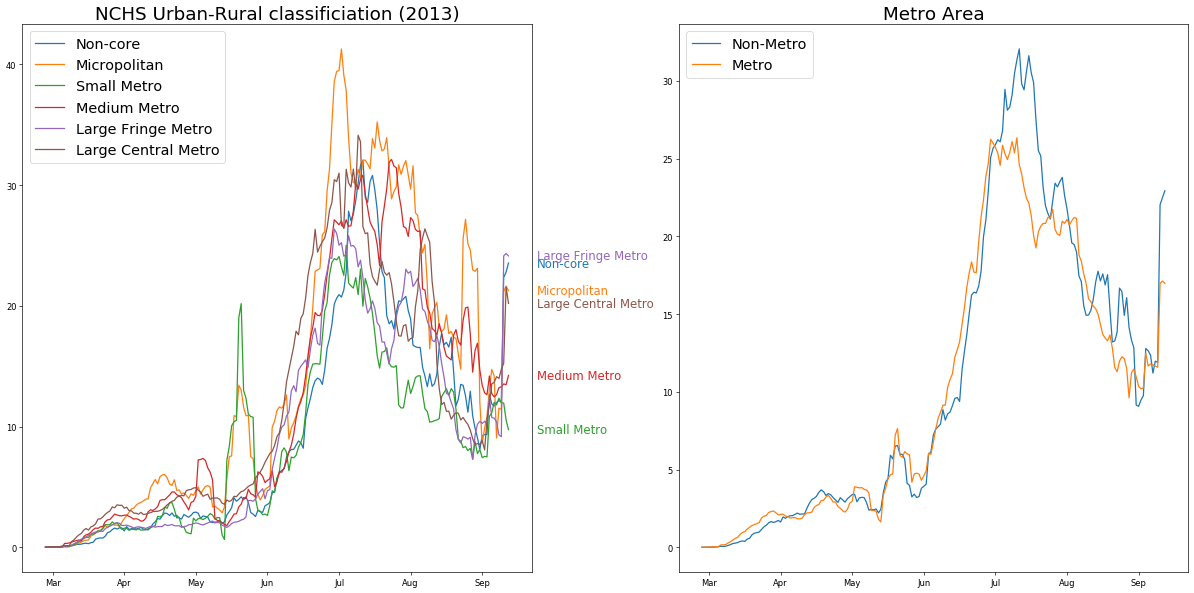

In [105]:
# create figure
fig = plt.figure(figsize=figsize, dpi=60)
#fig.suptitle('Daily case count per 100,000 of population', fontsize=32)
# and its subplots
ax1 = fig.add_subplot(1, 2, 1)
config_subplot(ax1, 'NCHS Urban-Rural classificiation (2013)', title_size, ticker_count)
ax2 = fig.add_subplot(1, 2, 2)
config_subplot(ax2, 'Metro Area', title_size, ticker_count)

# plotting average values of each metro classification
# for label, df in merged_df.groupby('Classification', sort=True):
metro_cls = ['Non-core', 'Micropolitan', 'Small Metro', 'Medium Metro', 'Large Fringe Metro', 'Large Central Metro']
for cls in metro_cls:
    df = merged_df[merged_df['Classification'] == cls].iloc[:,:-2]
    df = df.mean().diff().rolling(window=7).mean()
    #print(df.iloc[:,:-1].max().max())
    ax1.plot(dates, df, label=cls)

# plotting average values of each metro classification
metro_types = ['Non-Metro', 'Metro']
for metro_type in metro_types:
    df = merged_df[merged_df['MetroArea'] == metro_type].iloc[:,:-2]
    df = df.mean().diff().rolling(window=7).mean()
    ax2.plot(dates, df, label=metro_type)

# configure legend
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, loc='upper left', fontsize='xx-large')
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles, labels, loc='upper left', fontsize='xx-large')

# configure legend on lines
for line, name in zip(ax1.lines, metro_cls):
    y = line.get_ydata()[-1]
    ax1.annotate(name, xy=(1,y), xytext=(6,0), color=line.get_color(), 
                xycoords = ax1.get_yaxis_transform(), textcoords="offset points",
                size=14, va="center")
    
fig.tight_layout()

## Heatmap

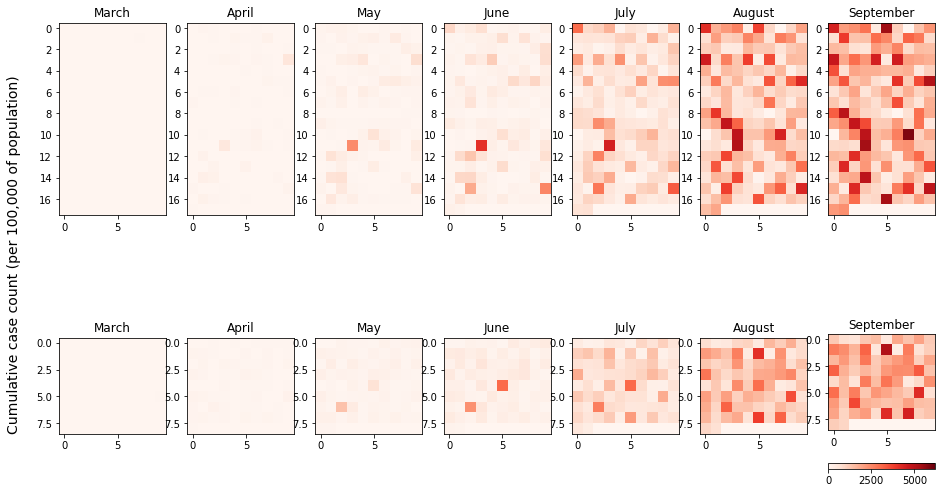

In [222]:
import numpy as np
import calendar
from matplotlib.pyplot import cm

fig_size = 6
fig2 = plt.figure(figsize=(fig_size*3, fig_size*1.5))
fig2.suptitle('', fontsize=32)
fig2.text(0.085, 0.5, "Cumulative case count (per 100,000 of population)", va="center", rotation=90, fontsize=14)

idx = 0
vmax = merged_df.iloc[:,:-2].max().max()
for i, metro_type in enumerate(metro_types):
    for month in range(1,12,1):
        df = merged_df[merged_df['MetroArea'] == metro_type].iloc[:,:-2]
        df = df.filter(like='{:02d}-'.format(month))
        if df.shape[1] > 0:
            df = df.mean(axis=1).to_numpy(dtype='float')
            df = np.pad(df, (0,10-df.shape[0]%10), 'constant')
            df = df.reshape((-1,10))
            
            idx += 1
            ax = fig2.add_subplot(2, 8, idx)
            ax.set_title(calendar.month_name[month], fontdict={'fontsize':12})
            heatmap = ax.imshow(df, cmap=cm.Reds, vmax=vmax)
    idx = 8
    
fig2.colorbar(heatmap, orientation="horizontal")
            
fig2.savefig('Hypothesis_8_2.png')